In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'
other_file_dir = 'D:\\Ising_model_results_daai'

In [4]:
training_subject_start=0
training_subject_end = 670

In [5]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [6]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
    axs.hist(  depytorch( values.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [7]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [8]:
def get_closest_match(values:torch.Tensor, target:float):
    return torch.argmin( torch.abs(values - target) )

In [9]:
def make_scatter_plot_with_regression_line(ax, feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str):
    # We assume both Tensors are 1D and the same size.
    
    feature_and_1 = torch.stack(  ( feature, torch.ones_like(feature) ), dim=-1  )
    param_col = param.unsqueeze(dim=-1)
    lst_sq_result = torch.linalg.lstsq(feature_and_1, param_col)
    param_pred = torch.matmul(feature_and_1, lst_sq_result.solution).flatten()
    param_mean = torch.mean(param)
    r_squared = 1 - torch.sum( torch.square(param - param_pred) )/torch.sum( torch.square(param - param_mean) )
    corr = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature, dim=0)
    
    slope = lst_sq_result.solution[0].item()
    intercept = lst_sq_result.solution[1].item()
    print(f'{param_name}={slope:.3g}{feature_name}+{intercept:.3g}, R^2={r_squared:.3g}, corr.={corr:.3g}')
    
    feature_np = depytorch(feature)
    param_np = depytorch(param)
    param_pred_np = depytorch(param_pred)
    ax.scatter(feature_np, param_np, color='blue')
    ax.plot(feature_np, param_pred_np, color='orange', linewidth=3)
    # ax.text( x=0.0, y=param_mean.item(), s=f'R^2={r_squared:.3g}, corr.={corr:.3g}' )
    ax.set_xlabel(f'{feature_name}')
    ax.set_ylabel(f'{param_name}')
    return slope, intercept

In [10]:
plt.rcParams.update({'font.size': 20})
line_width = 3

In [11]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)

In [247]:
J_inv_cov_corr = torch.load( os.path.join(file_dir, 'J_inv_cov_corr_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False )
print( J_inv_cov_corr.size() )

torch.Size([101, 31])


In [245]:
J_inv_cov_corr = torch.load( os.path.join(file_dir, 'corr_J_inv_cov_as_is_h_0_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False )
print( J_inv_cov_corr.size() )

torch.Size([101, 31])


In [227]:
J_inv_cov_corr = torch.load( os.path.join(file_dir, 'J_inv_cov_corr_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_thresh_0.pt'), weights_only=False )
print( J_inv_cov_corr.size() )

torch.Size([101, 31])


In [202]:
corr_is_non_nan = torch.logical_not( torch.isnan(J_inv_cov_corr) )
num_non_nan = torch.count_nonzero(corr_is_non_nan)
print(f'{num_non_nan} of {corr_is_non_nan.numel()} correlations are not NaN.')

3131 of 3131 correlations are not NaN.


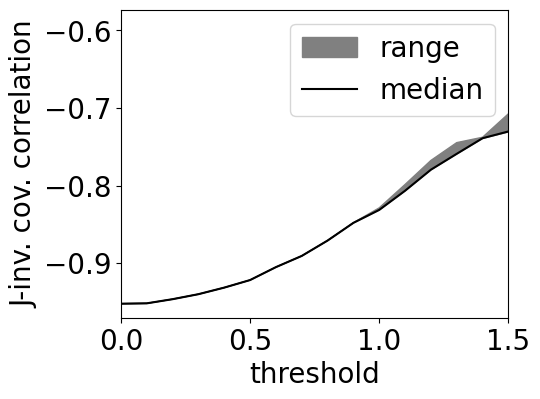

In [248]:
min_corr = torch.min(J_inv_cov_corr, dim=0).values
median_corr = torch.median(J_inv_cov_corr, dim=0).values
max_corr = torch.max(J_inv_cov_corr, dim=0).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between( depytorch(threshold), depytorch(min_corr), depytorch(max_corr), color=[0.5, 0.5, 0.5], label='range' )
ax.plot( depytorch(threshold), depytorch(median_corr), color=[0.0, 0.0, 0.0], label='median' )
ax.set_xlabel('threshold')
ax.set_ylabel('J-inv. cov. correlation')
ax.set_xlim([0.0, 1.5])
ax.legend()

In [216]:
threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[threshold_index]
print(f'at threshold {selected_threshold:.3g}, J-inverse covariance correlation has min {min_corr[threshold_index]:.3g}, median {median_corr[threshold_index]:.3g}, max {max_corr[threshold_index]:.3g}, range {max_corr[threshold_index]-min_corr[threshold_index]:.3g}')

at threshold 1, J-inverse covariance correlation has min -0.601, median -0.601, max -0.598, range 0.00248


In [105]:
inv_cov = torch.load( os.path.join(file_dir, 'inv_cov_mean_state_product_thresholds_31_min_0_max_3.pt'), weights_only=False )
print( inv_cov.size() )

torch.Size([31, 360, 360])


In [205]:
inv_cov = torch.load( os.path.join(file_dir, 'inv_cov_J_inv_cov_as_is_h_0.pt'), weights_only=False )
print( inv_cov.size() )

torch.Size([31, 360, 360])


In [190]:
inv_cov = torch.load( os.path.join(file_dir, 'inv_cov_mean_state_product_thresholds_31_min_0_max_3_thresh_0.pt'), weights_only=False )
print( inv_cov.size() )

torch.Size([31, 360, 360])


In [108]:
J = torch.load( os.path.join(file_dir, 'ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False ).J.mean(dim=0)
print( J.size() )

torch.Size([31, 360, 360])


In [217]:
triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=J.size(dim=-1), device=J.device )
inv_cov_triu = inv_cov[:,triu_rows,triu_cols]
print( inv_cov_triu.size() )
J_triu = J[:,triu_rows,triu_cols]
print( J_triu.size() )

torch.Size([31, 64620])
torch.Size([31, 64620])


In [218]:
J_at_thresh = J[threshold_index,:,:]
print( J_at_thresh.min().item(), J_at_thresh.median().item(), J_at_thresh.max().item(), J_at_thresh[0,0].item() )

-9.544092178344727 0.009343018755316734 59.3947639465332 -3.346940502524376e-10


In [219]:
inv_cov_at_thresh = inv_cov[threshold_index,:,:]
print( inv_cov_at_thresh.min().item(), inv_cov_at_thresh.median().item(), inv_cov_at_thresh.max().item(), inv_cov_at_thresh[0,0].item() )

-11.578377723693848 0.0006762892007827759 22.1457462310791 15.467199325561523


[]

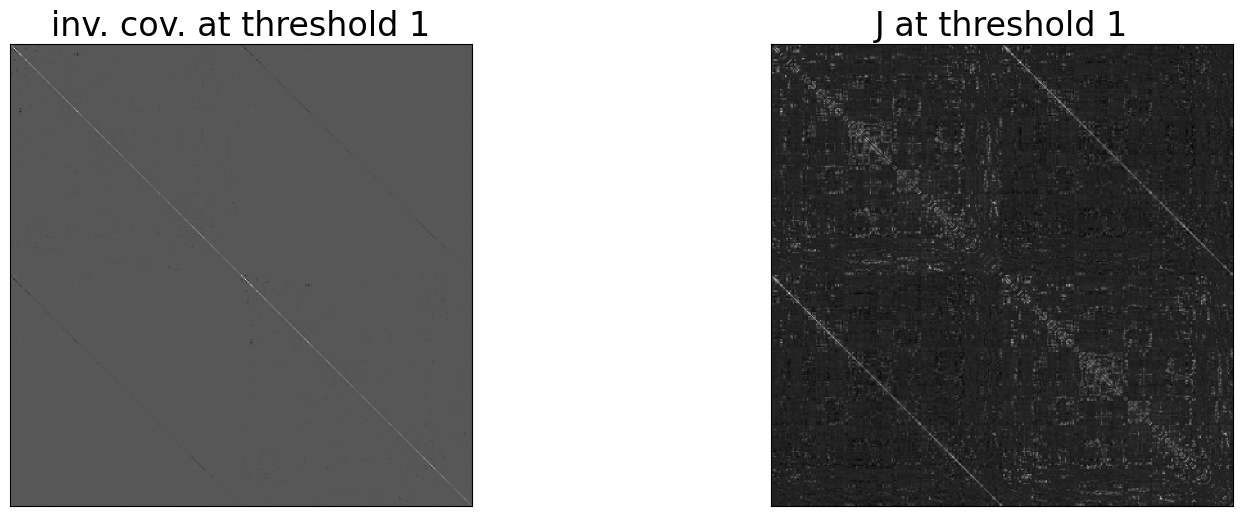

In [220]:
cmap = 'gray'
fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(18, 6) )
ax = axs[0]
ax.imshow( depytorch(inv_cov[threshold_index,:,:]), cmap=cmap )
ax.set_title(f'inv. cov. at threshold {selected_threshold:.3g}')
ax.set_xticks([])
ax.set_yticks([])
ax = axs[1]
ax.imshow( depytorch(J[threshold_index,:,:]), cmap=cmap )
ax.set_title(f'J at threshold {selected_threshold:.3g}')
ax.set_xticks([])
ax.set_yticks([])

[]

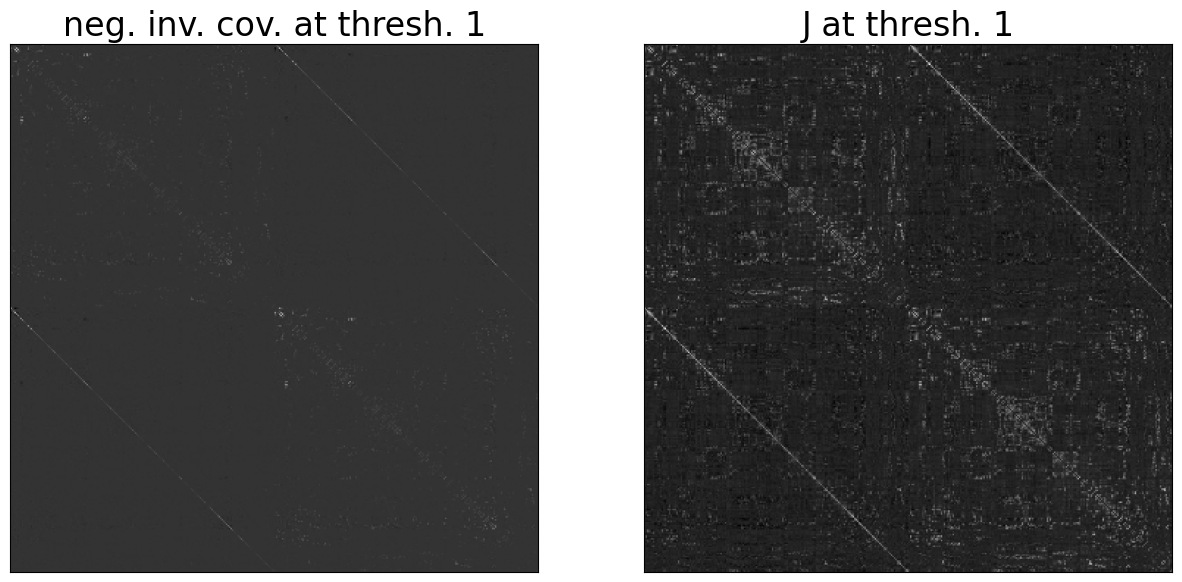

In [221]:
cmap = 'gray'
fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(15, 10) )
ax = axs[0]
neg_inv_cov_at_thresh = -inv_cov[threshold_index,:,:]
neg_inv_cov_no_diag = neg_inv_cov_at_thresh - torch.diag_embed( torch.diagonal(neg_inv_cov_at_thresh) )
ax.imshow( depytorch(neg_inv_cov_no_diag), cmap=cmap )
ax.set_title(f'neg. inv. cov. at thresh. {selected_threshold:.3g}')
ax.set_xticks([])
ax.set_yticks([])
ax = axs[1]
ax.imshow( depytorch(J[threshold_index,:,:]), cmap=cmap )
ax.set_title(f'J at thresh. {selected_threshold:.3g}')
ax.set_xticks([])
ax.set_yticks([])

J at threshold 1=-13.2inv. cov. at threshold 1+0.643, R^2=0.36, corr.=-0.6


(-13.205403327941895, 0.6429309248924255)

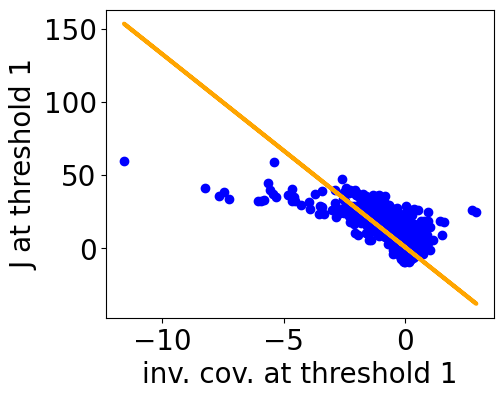

In [222]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=inv_cov_triu[threshold_index,:], param=J_triu[threshold_index,:], feature_name=f'inv. cov. at threshold {selected_threshold:.3g}', param_name=f'J at threshold {selected_threshold:.3g}' )

J at threshold 0=-8.44continuous-valued inv. cov.+0.211, R^2=0.572, corr.=-0.756


(-8.44291877746582, 0.21062634885311127)

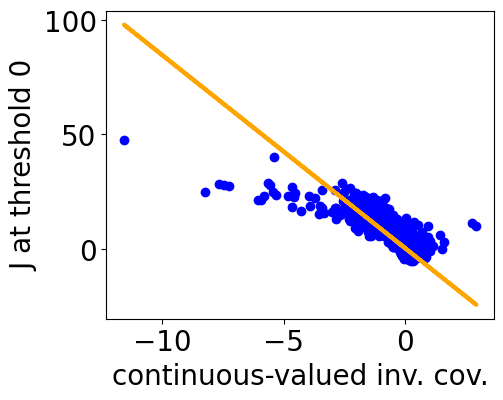

In [215]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=inv_cov_triu[threshold_index,:], param=J_triu[threshold_index,:], feature_name=f'continuous-valued inv. cov.', param_name=f'J at threshold {selected_threshold:.3g}' )

J at threshold 1=-83.7inv. cov. at threshold 0+0.336, R^2=0.708, corr.=-0.842


(-83.71849822998047, 0.3364272117614746)

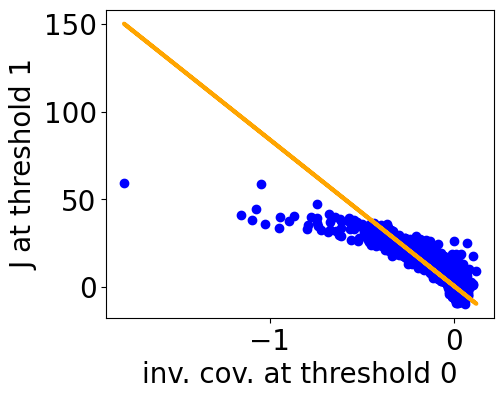

In [199]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=inv_cov_triu[threshold_index,:], param=J_triu[threshold_index,:], feature_name=f'inv. cov. at threshold 0', param_name=f'J at threshold {selected_threshold:.3g}' )

In [164]:
offset = 0.000001
neg_inv_cov_triu = -1*inv_cov_triu
offset_neg_inv_cov_triu = neg_inv_cov_triu - neg_inv_cov_triu.min(dim=-1, keepdim=True).values + offset
log_offset_neg_inv_cov_triu = torch.log(offset_neg_inv_cov_triu)

In [165]:
offset_J_triu = J_triu - J_triu.min(dim=-1, keepdim=True).values + offset
log_offset_J_triu = torch.log(offset_J_triu)

log offset J at threshold 1=1.15log offset neg. inv. cov. at thresh. 1+4.72, R^2=0.566, corr.=0.752


(1.1501209735870361, 4.715979099273682)

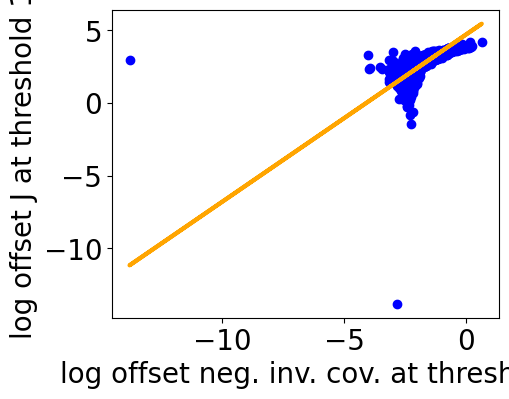

In [166]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=log_offset_neg_inv_cov_triu[threshold_index,:], param=log_offset_J_triu[threshold_index,:], feature_name=f'log offset neg. inv. cov. at thresh. {selected_threshold:.3g}', param_name=f'log offset J at threshold {selected_threshold:.3g}' )

In [167]:
abs_inv_cov_triu = torch.abs(inv_cov_triu)
log_abs_inv_cov_triu = torch.log(abs_inv_cov_triu)
abs_J_triu = torch.abs(J_triu)
log_abs_J_triu = torch.log(abs_J_triu)

log. abs. J at thresh. 1=0.479log. abs. inv. cov. at thresh. 1+2.51, R^2=0.245, corr.=0.495


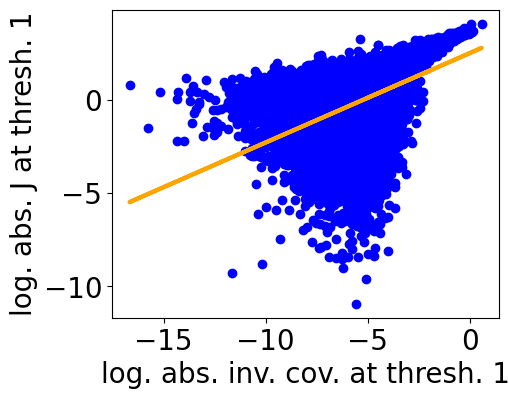

In [181]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
slope, intercept = make_scatter_plot_with_regression_line( ax, feature=log_abs_inv_cov_triu[threshold_index,:], param=log_abs_J_triu[threshold_index,:], feature_name=f'log. abs. inv. cov. at thresh. {selected_threshold:.3g}', param_name=f'log. abs. J at thresh. {selected_threshold:.3g}' )

In [169]:
J_triu_at_thresh = J_triu[threshold_index,:]
J_is_pos = J_triu_at_thresh > 0
J_is_non_pos = torch.logical_not(J_is_pos)
J_triu_at_thresh_non_pos = J_triu_at_thresh[J_is_non_pos]
print(f'{J_triu_at_thresh_non_pos.numel()} J values are non-positive with min {J_triu_at_thresh_non_pos.min():.3g}, median {J_triu_at_thresh_non_pos.median():.3g}, max {J_triu_at_thresh_non_pos.max():.3g}.')
J_triu_at_thresh_pos = J_triu_at_thresh[J_is_pos]
print(f'{J_triu_at_thresh_pos.numel()} J values are positive with min {J_triu_at_thresh_pos.min():.3g}, median {J_triu_at_thresh_pos.median():.3g}, max {J_triu_at_thresh_pos.max():.3g}.')
neg_inv_cov_triu_at_thresh = neg_inv_cov_triu[threshold_index,:]
neg_inv_cov_is_pos = neg_inv_cov_triu_at_thresh > 0
neg_inv_cov_is_non_pos = torch.logical_not(neg_inv_cov_is_pos)
neg_inv_cov_triu_at_thresh_non_pos = neg_inv_cov_triu_at_thresh[neg_inv_cov_is_non_pos]
print(f'{neg_inv_cov_triu_at_thresh_non_pos.numel()} -inv(cov) values are non-positive with min {neg_inv_cov_triu_at_thresh_non_pos.min():.3g}, median {neg_inv_cov_triu_at_thresh_non_pos.median():.3g}, max {neg_inv_cov_triu_at_thresh_non_pos.max():.3g}.')
neg_inv_cov_triu_at_thresh_pos = neg_inv_cov_triu_at_thresh[neg_inv_cov_is_pos]
print(f'{neg_inv_cov_triu_at_thresh_pos.numel()} -inv(cov) values are positive with min {neg_inv_cov_triu_at_thresh_pos.min():.3g}, median {neg_inv_cov_triu_at_thresh_pos.median():.3g}, max {neg_inv_cov_triu_at_thresh_pos.max():.3g}.')

32073 J values are non-positive with min -9.54, median -1.05, max -1.8e-05.
32547 J values are positive with min 6.73e-05, median 1.28, max 59.4.
32749 -inv(cov) values are non-positive with min -0.118, median -0.00591, max -5.94e-07.
31871 -inv(cov) values are positive with min 5.74e-08, median 0.00635, max 1.79.


In [170]:
neg_inv_cov_triu_sorted, neg_inv_cov_triu_sort_indices = torch.sort(neg_inv_cov_triu[threshold_index,:])
J_triu_sorted = J_triu[threshold_index,neg_inv_cov_triu_sort_indices]
num_edges = neg_inv_cov_triu_sorted.numel()
corr_above_cutoff = torch.zeros_like(neg_inv_cov_triu_sorted)
log_neg_inv_cov_triu_sorted = torch.log(neg_inv_cov_triu_sorted)
log_J_triu_sorted = torch.log(J_triu_sorted)
for edge_index in range(num_edges-1):
    corr_above_cutoff[edge_index] = isingmodellight.get_pairwise_correlation(mat1=log_neg_inv_cov_triu_sorted[edge_index:], mat2=log_J_triu_sorted[edge_index:], epsilon=0.0, dim=0)

Text(0, 0.5, 'J-neg. inv. cov. correlation')

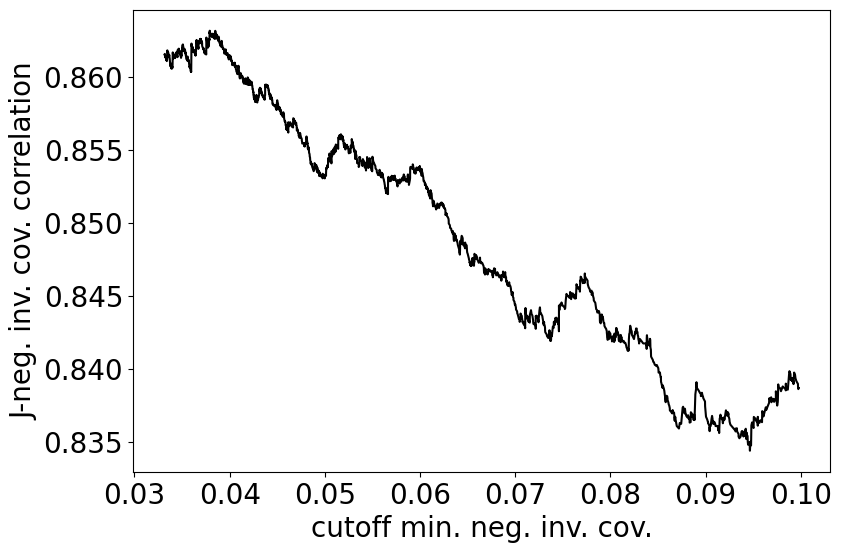

In [174]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
max_index = get_closest_match(values=neg_inv_cov_triu_sorted, target=0.1)
ax.plot( depytorch(neg_inv_cov_triu_sorted[:max_index]), depytorch(corr_above_cutoff[:max_index]), color=[0.0, 0.0, 0.0], label='median' )
ax.set_xlabel('cutoff min. neg. inv. cov.')
ax.set_ylabel('J-neg. inv. cov. correlation')
# ax.set_xlim([0.0, 0.5])

In [175]:
corr_is_not_nan = torch.logical_not( torch.isnan(corr_above_cutoff) )
non_nan_cutoffs = neg_inv_cov_triu_sorted[corr_is_not_nan]
non_nan_corrs = corr_above_cutoff[corr_is_not_nan]
best_corr_index = torch.argmax(non_nan_corrs)
best_corr = non_nan_corrs[best_corr_index]
best_cutoff = non_nan_cutoffs[best_corr_index]
print(f'The maximum correlation in log-log space {best_corr:.3g} occurs is when minimum negative inverse covariance is {best_cutoff:.3g}, excludes {best_corr_index} edges.')

The maximum correlation in log-log space 0.863 occurs is when minimum negative inverse covariance is 0.0379, excludes 425 edges.


In [176]:
best_cutoff_neg_inv_cov = best_cutoff

In [177]:
neg_inv_cov_triu = -1*inv_cov_triu
is_big_enough = torch.logical_and( neg_inv_cov_triu > best_cutoff_neg_inv_cov, J_triu > 0 )
is_big_enough_at_threshold = is_big_enough[threshold_index,:]
big_neg_inv_cov_triu = neg_inv_cov_triu[threshold_index,is_big_enough_at_threshold]
log_big_neg_inv_cov_triu = torch.log(big_neg_inv_cov_triu)
big_J_triu = J_triu[threshold_index,is_big_enough_at_threshold]
log_big_J_triu = torch.log(big_J_triu)
print( f'{torch.count_nonzero(is_big_enough_at_threshold)} of {is_big_enough_at_threshold.numel()} points remaining' )

3663 of 64620 points remaining


log J=0.6log. neg. inv. cov. > 0.0379+3.89, R^2=0.745, corr.=0.863


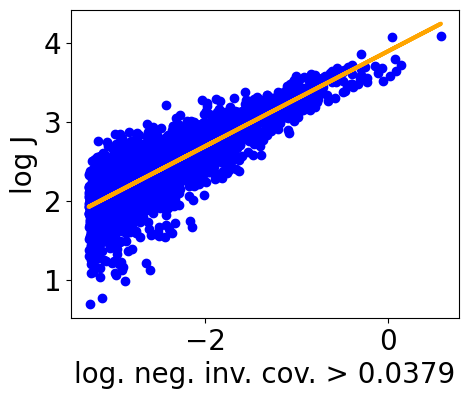

In [178]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
slope, intercept = make_scatter_plot_with_regression_line( ax, feature=log_big_neg_inv_cov_triu, param=log_big_J_triu, feature_name=f'log. neg. inv. cov. > {best_cutoff_neg_inv_cov:.3g}', param_name=f'log J' )

In [182]:
inv_cov_pow_triu = intercept * torch.sign(neg_inv_cov_triu_at_thresh) * torch.pow( torch.abs(neg_inv_cov_triu_at_thresh), slope )
inv_cov_pow_triu_is_not_nan = torch.logical_not( torch.isnan(inv_cov_pow_triu) )
inv_cov_pow_triu_non_nan = inv_cov_pow_triu[inv_cov_pow_triu_is_not_nan]
J_triu_non_nan = J_triu[threshold_index,inv_cov_pow_triu_is_not_nan]
print( torch.count_nonzero(inv_cov_pow_triu_is_not_nan) )

tensor(64620, device='cuda:0')


J=9.77power law of neg. inv. cov.+0.55, R^2=0.633, corr.=0.796


(9.77153491973877, 0.5504223704338074)

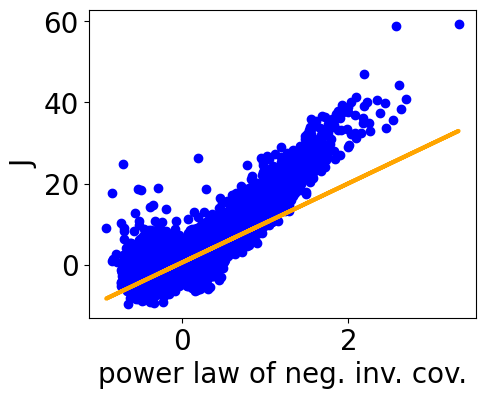

In [183]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=inv_cov_pow_triu_non_nan, param=J_triu_non_nan, feature_name=f'power law of neg. inv. cov.', param_name=f'J' )

In [109]:
J_triu_sorted, J_triu_sort_indices = torch.sort(J_triu[threshold_index,:])
neg_inv_cov_triu_sorted = neg_inv_cov_triu[threshold_index,J_triu_sort_indices]
num_edges = J_triu_sorted.numel()
corr_above_cutoff = torch.zeros_like(J_triu_sorted)
log_neg_inv_cov_triu_sorted = torch.log(neg_inv_cov_triu_sorted)
log_J_triu_sorted = torch.log(J_triu_sorted)
for edge_index in range(num_edges-1):
    corr_above_cutoff[edge_index] = isingmodellight.get_pairwise_correlation(mat1=log_neg_inv_cov_triu_sorted[edge_index:], mat2=log_J_triu_sorted[edge_index:], epsilon=0.0, dim=0)

Text(0, 0.5, 'J-inverse covariance correlation')

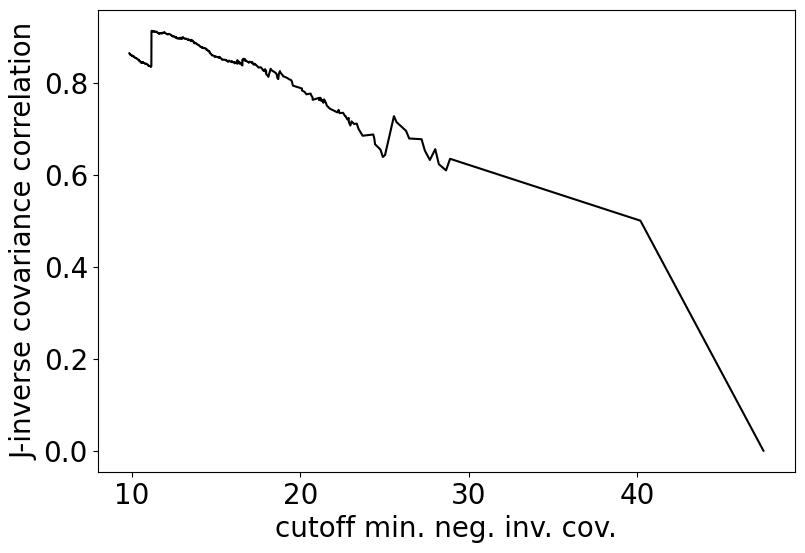

In [111]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
max_index = num_edges# get_closest_match(values=neg_inv_cov_triu_sorted, target=0.05)
ax.plot( depytorch(J_triu_sorted[:max_index]), depytorch(corr_above_cutoff[:max_index]), color=[0.0, 0.0, 0.0], label='median' )
ax.set_xlabel('cutoff min. neg. inv. cov.')
ax.set_ylabel('J-inverse covariance correlation')
# ax.set_xlim([0.0, 0.25])

In [112]:
corr_is_not_nan = torch.logical_not( torch.isnan(corr_above_cutoff) )
non_nan_cutoffs = J_triu_sorted[corr_is_not_nan]
non_nan_corrs = corr_above_cutoff[corr_is_not_nan]
best_corr_index = torch.argmax(non_nan_corrs)
best_corr = non_nan_corrs[best_corr_index]
best_cutoff = non_nan_cutoffs[best_corr_index]
print(f'The maximum correlation in log-log space {best_corr:.3g} occurs is when minimum J is {best_cutoff:.3g}, excludes {best_corr_index} edges.')

The maximum correlation in log-log space 0.913 occurs is when minimum J is 11.2, excludes 169 edges.


In [44]:
h = torch.load( os.path.join(file_dir, 'ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False ).h.mean(dim=0)
print( h.size() )

torch.Size([31, 360])


In [58]:
model = torch.load( os.path.join(file_dir, 'ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False )
h = torch.mean( model.h * model.beta.unsqueeze(dim=-1), dim=0 )
print( h.size() )

torch.Size([31, 360])


In [59]:
mean_state = torch.load( os.path.join(file_dir, 'mean_state_thresholds_31_min_0_max_3.pt'), weights_only=False )
print( mean_state.size() )

torch.Size([31, 360])


In [60]:
mean_state_corr = isingmodellight.get_pairwise_correlation(mat1=h, mat2=mean_state, epsilon=0, dim=-1)
print( mean_state_corr.size() )

torch.Size([31])


(0.0, 3.0)

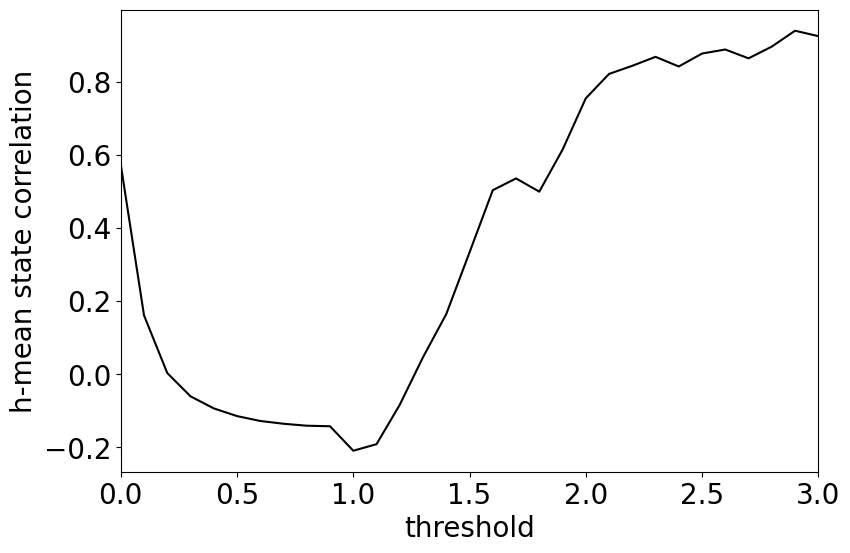

In [61]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.plot( depytorch(threshold), depytorch(mean_state_corr), color=[0.0, 0.0, 0.0] )
ax.set_xlabel('threshold')
ax.set_ylabel('h-mean state correlation')
ax.set_xlim([0.0, 3.0])

In [66]:
threshold_index = get_closest_match(values=threshold, target=2.0)
selected_threshold = threshold[threshold_index]
print(f'At threshold {selected_threshold:.3g}, h-mean-state correlation is {mean_state_corr[threshold_index]:.3g}.')

At threshold 2, h-mean-state correlation is 0.754.


h at threshold 2=1.55mean state at threshold 2+1.42, R^2=0.572, corr.=0.754


(1.5484697818756104, 1.4174679517745972)

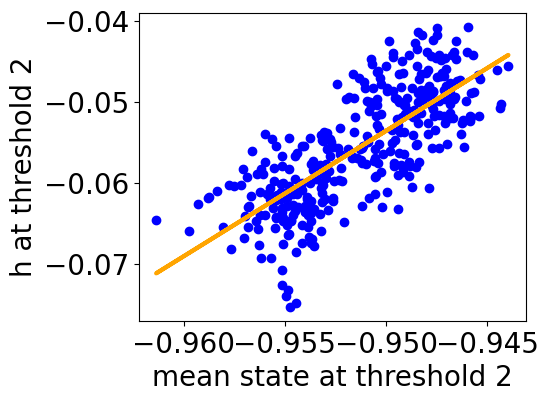

In [67]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=mean_state[threshold_index,:], param=h[threshold_index,:], feature_name=f'mean state at threshold {selected_threshold:.3g}', param_name=f'h at threshold {selected_threshold:.3g}' )

In [68]:
neg_inv_mean_state = -1.0/mean_state

In [69]:
neg_inv_mean_state_corr = isingmodellight.get_pairwise_correlation(mat1=h, mat2=neg_inv_mean_state, epsilon=0, dim=-1)
print( mean_state_corr.size() )

torch.Size([31])


(0.0, 3.0)

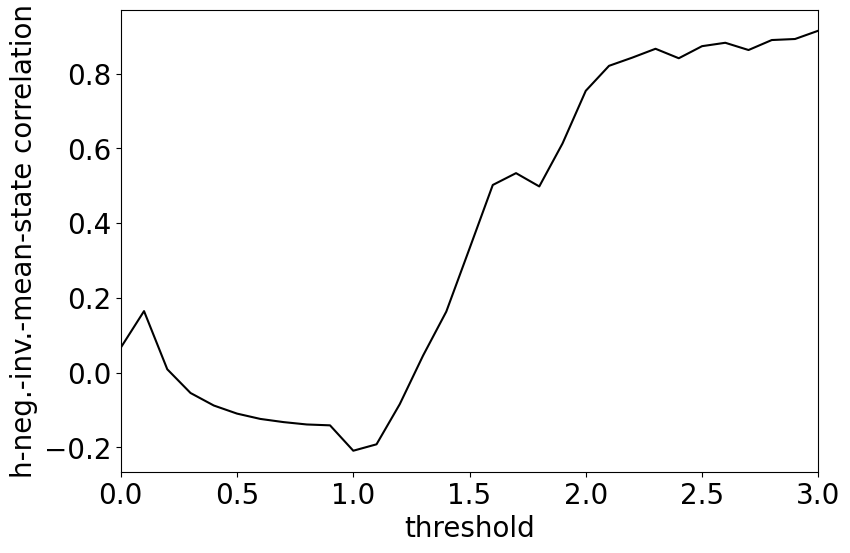

In [70]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.plot( depytorch(threshold), depytorch(neg_inv_mean_state_corr), color=[0.0, 0.0, 0.0] )
ax.set_xlabel('threshold')
ax.set_ylabel('h-neg.-inv.-mean-state correlation')
ax.set_xlim([0.0, 3.0])

In [ ]:
model = torch.load( f=os.path.join(file_dir, 'ising_model_light_group_inv_cov_thresh_num_31_min_0_max_3_beta_num_101_min_1e-10_max_1_updates_8_param_updates_1000.pt'), weights_only=False )
print( model.beta.size() )

In [299]:
print( model.beta.max(dim=0).values - model.beta.min(dim=0).values )

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


In [74]:
threshold_index = get_closest_match(values=threshold, target=0.5)
selected_threshold = threshold[threshold_index]
print(f'At threshold {selected_threshold:.3g}, h-neg-inv-mean-state correlation is {neg_inv_mean_state_corr[threshold_index]:.3g}.')

At threshold 0.5, h-neg-inv-mean-state correlation is -0.11.


In [12]:
fc_corr = torch.load( os.path.join(file_dir, 'fc_corr_J_inv_cov_thresh_num_31_min_0_max_3_h_0_test_beta_min_1e-10_max_1_sim_steps_120000.pt'), weights_only=False )
print( fc_corr.size() )

torch.Size([101, 31])


In [14]:
fc_corr = torch.load( os.path.join(file_dir, 'fc_corr_group_thresholds_31_min_0_max_3_as_is_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_test_length_120000.pt'), weights_only=False )
print( fc_corr.size() )

torch.Size([101, 31])


In [273]:
fc_corr = torch.load( os.path.join(file_dir, 'fc_corr_J_inv_cov_thresh_num_31_min_0_max_3_h_mean_test_beta_min_1e-10_max_1_sim_steps_120000.pt'), weights_only=False )
print( fc_corr.size() )

torch.Size([101, 31])


In [12]:
fc_corr = torch.load( os.path.join(file_dir, 'fc_corr_J_inv_cov_thresh_num_31_min_0_max_3_test_beta_min_1e-10_max_1_sim_steps_120000.pt'), weights_only=False )
print( fc_corr.size() )

torch.Size([101, 31])


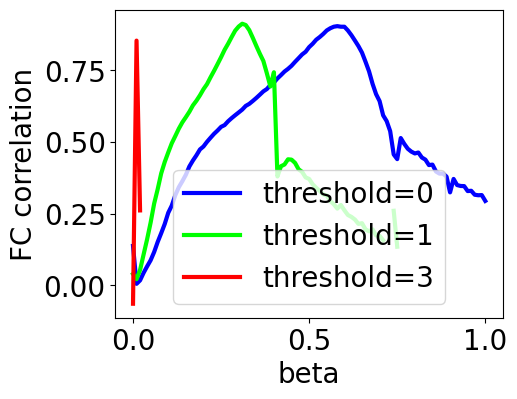

In [13]:
blue_thresh = get_closest_match(threshold, 0.0)
blue_cval = [0.0, 0.0, 1.0]
green_thresh = get_closest_match(threshold, 1.0)
green_cval = [0.0, 1.0, 0.0]
red_thresh = get_closest_match(threshold, 3.0)
red_cval = [1.0, 0.0, 0.0]
selected_indices = [blue_thresh, green_thresh, red_thresh]
selected_colors = [blue_cval, green_cval, red_cval]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
test_beta = torch.linspace(start=1e-10, end=1.0, steps=101, dtype=float_type, device=device)
test_beta_np = depytorch(test_beta)
fc_corr_beta_test_np = depytorch(fc_corr)
line_width = 3.0
num_beta = test_beta.size(dim=0)
max_beta_index = num_beta
# max_beta_index = torch.argmin( torch.abs(test_beta - 0.02) )
for threshold_index, cval in zip(selected_indices,selected_colors):
    axs.plot( test_beta_np[:max_beta_index], fc_corr_beta_test_np[:max_beta_index,threshold_index], color=cval, linewidth=line_width, label=f'threshold={threshold[threshold_index]:.3g}' )
axs.set_xlabel('beta')
axs.set_ylabel('FC correlation')
axs.legend()
plt.show()

In [14]:
# best_fc_corr, best_fc_corr_beta_index = torch.max(fc_corr, dim=0)
# best_fc_beta = test_beta[best_fc_corr_beta_index]
best_fc_corr = torch.zeros_like(threshold)
best_fc_beta = torch.zeros_like(threshold)
num_thresholds = threshold.numel()
for threshold_index in range(num_thresholds):
    fc_corr_at_thresh = fc_corr[:,threshold_index]
    fc_corr_is_not_nan = torch.logical_not( torch.isnan(fc_corr_at_thresh) )
    fc_corr_non_nan = fc_corr_at_thresh[fc_corr_is_not_nan]
    beta_non_nan = test_beta[fc_corr_is_not_nan]
    best_beta_index = torch.argmax(fc_corr_non_nan)
    best_fc_corr_at_thresh = fc_corr_non_nan[best_beta_index]
    best_beta_at_thresh = beta_non_nan[best_beta_index]
    best_fc_corr[threshold_index] = best_fc_corr_at_thresh
    best_fc_beta[threshold_index] = best_beta_at_thresh
    print(f'At threshold {threshold[threshold_index]:.3g}, optimal beta {best_beta_at_thresh:.3g}, FC correlation is {best_fc_corr_at_thresh:.3g}.')

At threshold 0, optimal beta 0.58, FC correlation is 0.904.
At threshold 0.1, optimal beta 0.58, FC correlation is 0.904.
At threshold 0.2, optimal beta 0.57, FC correlation is 0.904.
At threshold 0.3, optimal beta 0.54, FC correlation is 0.905.
At threshold 0.4, optimal beta 0.52, FC correlation is 0.903.
At threshold 0.5, optimal beta 0.49, FC correlation is 0.903.
At threshold 0.6, optimal beta 0.46, FC correlation is 0.903.
At threshold 0.7, optimal beta 0.42, FC correlation is 0.904.
At threshold 0.8, optimal beta 0.38, FC correlation is 0.906.
At threshold 0.9, optimal beta 0.35, FC correlation is 0.91.
At threshold 1, optimal beta 0.31, FC correlation is 0.913.
At threshold 1.1, optimal beta 0.28, FC correlation is 0.915.
At threshold 1.2, optimal beta 0.25, FC correlation is 0.919.
At threshold 1.3, optimal beta 0.22, FC correlation is 0.923.
At threshold 1.4, optimal beta 0.19, FC correlation is 0.93.
At threshold 1.5, optimal beta 0.16, FC correlation is 0.932.
At threshold 1

In [15]:
print( best_fc_beta.tolist() )

[0.5799999833106995, 0.5799999833106995, 0.5699999928474426, 0.5400000214576721, 0.5199999809265137, 0.4899999797344208, 0.4599999785423279, 0.41999998688697815, 0.3799999952316284, 0.3499999940395355, 0.3100000023841858, 0.2800000011920929, 0.25, 0.2199999988079071, 0.1899999976158142, 0.1599999964237213, 0.14000000059604645, 0.11999999731779099, 0.10000000149011612, 0.08999999612569809, 0.07000000029802322, 0.05999999865889549, 0.05000000074505806, 0.03999999910593033, 0.029999999329447746, 0.019999999552965164, 0.029999999329447746, 0.009999999776482582, 0.009999999776482582, 1.000000013351432e-10, 0.009999999776482582]


In [16]:
threshold_index = get_closest_match(threshold, 1.0)
selected_threshold = threshold[threshold_index]
fc_corr_at_threshold = fc_corr[:,threshold_index]
fc_corr_at_threshold_non_nan = fc_corr_at_threshold[torch.logical_not( torch.isnan(fc_corr_at_threshold) )]
print(f'at threshold {selected_threshold:.3g}, FC correlation min {fc_corr_at_threshold_non_nan.min():.3g}, median {fc_corr_at_threshold_non_nan.median():.3g}, max {fc_corr_at_threshold_non_nan.max():.3g}')

at threshold 1, FC correlation min 0.022, median 0.405, max 0.913


Text(0, 0.5, 'optimal beta')

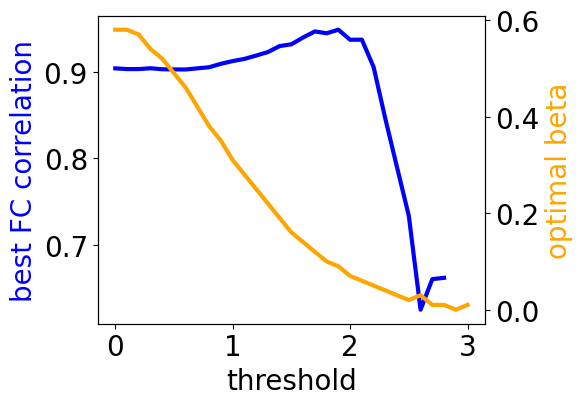

In [17]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
axs2 = axs.twinx()
threshold_np = depytorch(threshold)
axs.plot( threshold_np, depytorch(best_fc_corr), color='blue', linewidth=line_width )
axs.set_xlabel('threshold')
axs.set_ylabel('best FC correlation', color='blue')
axs2.plot( threshold_np, depytorch(best_fc_beta), color='orange', linewidth=line_width )
axs2.set_ylabel('optimal beta', color='orange')

In [18]:
cov_rmse = torch.load( os.path.join(file_dir, 'cov_rmse_J_inv_cov_thresh_num_31_min_0_max_3_h_0_test_beta_min_1e-10_max_1_sim_steps_120000.pt'), weights_only=False )
print( cov_rmse.size() )

torch.Size([101, 31])


In [19]:
cov_rmse = torch.load( os.path.join(file_dir, 'cov_rmse_J_inv_cov_thresh_num_31_min_0_max_3_test_beta_min_1e-10_max_1_sim_steps_120000.pt'), weights_only=False )
print( cov_rmse.size() )

torch.Size([101, 31])


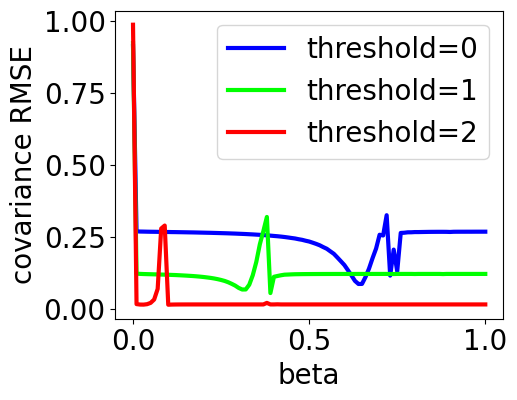

In [20]:
blue_thresh = get_closest_match(threshold, 0.0)
blue_cval = [0.0, 0.0, 1.0]
green_thresh = get_closest_match(threshold, 1.0)
green_cval = [0.0, 1.0, 0.0]
red_thresh = get_closest_match(threshold, 2.0)
red_cval = [1.0, 0.0, 0.0]
selected_indices = [blue_thresh, green_thresh, red_thresh]
selected_colors = [blue_cval, green_cval, red_cval]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
test_beta = torch.linspace(start=1e-10, end=1.0, steps=101, dtype=float_type, device=device)
test_beta_np = depytorch(test_beta)
cov_rmse_beta_test_np = depytorch(cov_rmse)
line_width = 3.0
num_beta = test_beta.size(dim=0)
max_beta_index = num_beta
# max_beta_index = torch.argmin( torch.abs(test_beta - 0.02) )
for threshold_index, cval in zip(selected_indices,selected_colors):
    axs.plot( test_beta_np[:max_beta_index], cov_rmse_beta_test_np[:max_beta_index,threshold_index], color=cval, linewidth=line_width, label=f'threshold={threshold[threshold_index]:.3g}' )
axs.set_xlabel('beta')
axs.set_ylabel('covariance RMSE')
axs.legend()
plt.show()

In [23]:
cov_rmse_after_fitting = torch.load( f=os.path.join(file_dir, 'cov_rmse_group_inv_cov_thresh_num_31_min_0_max_3_beta_num_101_min_1e-10_max_1_updates_8_param_updates_1000_test_length_120000.pt'), weights_only=False )
print( cov_rmse_after_fitting.size() )

torch.Size([101, 31])


In [291]:
model = torch.load( f=os.path.join(file_dir, 'ising_model_light_group_inv_cov_thresh_num_31_min_0_max_3_beta_num_101_min_1e-10_max_1_updates_8_param_updates_1000.pt'), weights_only=False )
print( model.beta.size() )

torch.Size([101, 31])


In [31]:
model = torch.load( f=os.path.join(file_dir, 'ising_model_light_group_J_inv_cov_h_0_thresh_num_31_min_0_max_3_beta_num_101_min_1e-10_max_1_updates_24_beta_length_120000_param_length_1200_param_updates_0.pt'), weights_only=False )
print( model.beta.size() )

torch.Size([101, 31])


In [32]:
print( model.beta.max(dim=0).values - model.beta.min(dim=0).values )

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


In [33]:
print( model.beta.mean(dim=0).tolist() )

[0.582838237285614, 0.5795605182647705, 0.5621337294578552, 0.549348771572113, 0.5209245085716248, 0.4924977421760559, 0.45589154958724976, 0.426024466753006, 0.3818243741989136, 0.34854018688201904, 0.3122692108154297, 0.2765950858592987, 0.24546191096305847, 0.2160687893629074, 0.1897525191307068, 0.16349554061889648, 0.13979530334472656, 0.12152288854122162, 0.10287085175514221, 0.0877862200140953, 0.8789958953857422, 0.6416082978248596, 0.49343714118003845, 0.39012250304222107, 0.37941598892211914, 0.02183910459280014, 0.0, 0.012628048658370972, 0.17938821017742157, 0.0, 0.10040409862995148]


In [25]:
min_rmse = torch.min(cov_rmse_after_fitting, dim=0).values
median_rmse = torch.median(cov_rmse_after_fitting, dim=0).values
max_rmse = torch.max(cov_rmse_after_fitting, dim=0).values

In [27]:
# best_fc_corr, best_fc_corr_beta_index = torch.max(fc_corr, dim=0)
# best_fc_beta = test_beta[best_fc_corr_beta_index]
best_cov_rmse = torch.zeros_like(threshold)
best_cov_rmse_beta = torch.zeros_like(threshold)
num_thresholds = threshold.numel()
for threshold_index in range(num_thresholds):
    cov_rmse_at_thresh = cov_rmse[:,threshold_index]
    cov_rmse_is_not_nan = torch.logical_not( torch.isnan(cov_rmse_at_thresh) )
    cov_rmse_non_nan = cov_rmse_at_thresh[cov_rmse_is_not_nan]
    beta_non_nan = test_beta[cov_rmse_is_not_nan]
    best_beta_index = torch.argmin(cov_rmse_non_nan)
    best_cov_rmse_at_thresh = cov_rmse_non_nan[best_beta_index]
    best_beta_at_thresh = beta_non_nan[best_beta_index]
    best_cov_rmse[threshold_index] = best_cov_rmse_at_thresh
    best_cov_rmse_beta[threshold_index] = best_beta_at_thresh
    print(f'At threshold {threshold[threshold_index]:.3g}, optimal beta {best_beta_at_thresh:.3g}, selected beta {model.beta[0,threshold_index]:.3g}, covariance RMSE is {best_cov_rmse_at_thresh:.3g}, after fitting has median {median_rmse[threshold_index]:.3g}, range [{min_rmse[threshold_index]:.3g}, {max_rmse[threshold_index]:.3g}].')

NameError: name 'model' is not defined

NameError: name 'best_cov_rmse' is not defined

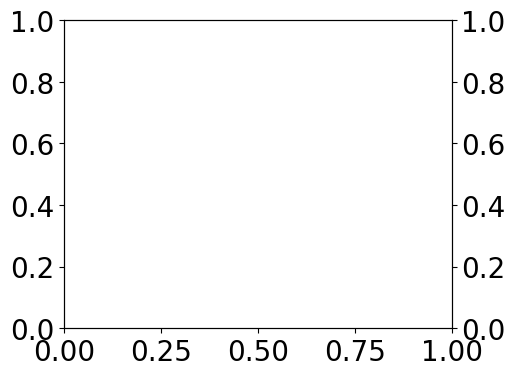

In [26]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
axs2 = axs.twinx()
threshold_np = depytorch(threshold)
axs.plot( threshold_np, depytorch(best_cov_rmse), color='blue', linewidth=line_width )
axs.set_xlabel('threshold')
axs.set_ylabel('best covariance RMSE', color='blue')
axs2.plot( threshold_np, depytorch(best_cov_rmse_beta), color='orange', linewidth=line_width )
axs2.set_ylabel('optimal beta', color='orange')

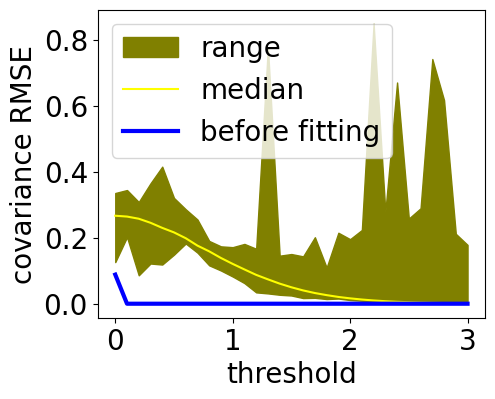

In [28]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between( depytorch(threshold), depytorch(min_rmse), depytorch(max_rmse), color=[0.5, 0.5, 0.0], label='range' )
ax.plot( depytorch(threshold), depytorch(median_rmse), color=[1.0, 1.0, 0.0], label='median' )
ax.plot( threshold_np, depytorch(best_cov_rmse), color='blue', linewidth=line_width, label='before fitting' )
ax.set_xlabel('threshold')
ax.set_ylabel('covariance RMSE')
# ax.set_xlim([0.0, 1.5])
ax.legend()

In [70]:
fc_corr_after_fitting = torch.load( f=os.path.join(file_dir, 'fc_corr_group_inv_cov_thresh_num_31_min_0_max_3_beta_num_101_min_1e-10_max_1_updates_8_param_updates_1000_test_length_120000.pt'), weights_only=False )
print( fc_corr_after_fitting.size() )

torch.Size([101, 31])


In [21]:
fc_corr_after_fitting = torch.load( f=os.path.join(file_dir, 'fc_corr_group_J_inv_cov_h_0_thresh_num_31_min_0_max_3_beta_num_101_min_1e-10_max_1_updates_24_beta_length_120000_param_length_1200_param_updates_30000_test_length_120000.pt'), weights_only=False )
print( fc_corr_after_fitting.size() )

torch.Size([101, 31])


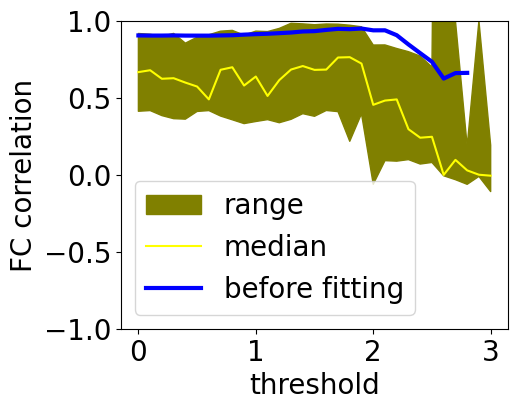

In [23]:
min_corr = torch.min(fc_corr_after_fitting, dim=0).values
median_corr = torch.median(fc_corr_after_fitting, dim=0).values
max_corr = torch.max(fc_corr_after_fitting, dim=0).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between( depytorch(threshold), depytorch(min_corr), depytorch(max_corr), color=[0.5, 0.5, 0.0], label='range' )
ax.plot( depytorch(threshold), depytorch(median_corr), color=[1.0, 1.0, 0.0], label='median' )
ax.plot( threshold_np, depytorch(best_fc_corr), color='blue', linewidth=line_width, label='before fitting' )
ax.set_xlabel('threshold')
ax.set_ylabel('FC correlation')
ax.set_ylim([-1.0, 1.0])
ax.legend()

In [72]:
fc_corr_after_fitting = torch.load( f=os.path.join(file_dir, 'fc_corr_group_inv_cov_thresh_num_31_min_0_max_3_beta_num_101_min_1e-10_max_1_updates_8_param_updates_10000_test_length_120000.pt'), weights_only=False )
print( fc_corr_after_fitting.size() )

torch.Size([101, 31])


In [24]:
min_corr = torch.min(fc_corr_after_fitting, dim=0).values
median_corr = torch.median(fc_corr_after_fitting, dim=0).values
max_corr = torch.max(fc_corr_after_fitting, dim=0).values
print(  torch.stack( tensors=(threshold, min_corr, median_corr, max_corr), dim=-1 )  )

tensor([[ 0.0000e+00,  4.1207e-01,  6.6623e-01,  9.1707e-01],
        [ 1.0000e-01,  4.1666e-01,  6.7857e-01,  9.1195e-01],
        [ 2.0000e-01,  3.8398e-01,  6.2305e-01,  8.9834e-01],
        [ 3.0000e-01,  3.6408e-01,  6.2683e-01,  9.1768e-01],
        [ 4.0000e-01,  3.6085e-01,  5.9827e-01,  8.5421e-01],
        [ 5.0000e-01,  4.1088e-01,  5.7259e-01,  8.9289e-01],
        [ 6.0000e-01,  4.1649e-01,  4.8927e-01,  9.0867e-01],
        [ 7.0000e-01,  3.8098e-01,  6.8143e-01,  9.3224e-01],
        [ 8.0000e-01,  3.5682e-01,  6.9787e-01,  9.3723e-01],
        [ 9.0000e-01,  3.3196e-01,  5.7905e-01,  9.0659e-01],
        [ 1.0000e+00,  3.4556e-01,  6.3759e-01,  9.3239e-01],
        [ 1.1000e+00,  3.5777e-01,  5.1154e-01,  9.2962e-01],
        [ 1.2000e+00,  3.3769e-01,  6.1450e-01,  9.5017e-01],
        [ 1.3000e+00,  3.5975e-01,  6.8299e-01,  9.8331e-01],
        [ 1.4000e+00,  3.9651e-01,  7.0571e-01,  9.7961e-01],
        [ 1.5000e+00,  3.7940e-01,  6.8081e-01,  9.7405e-01],
        

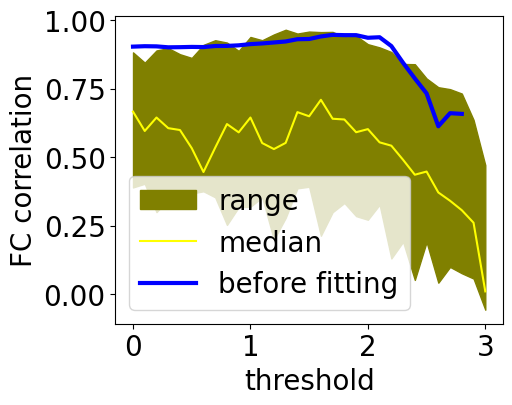

In [73]:
min_corr = torch.min(fc_corr_after_fitting, dim=0).values
median_corr = torch.median(fc_corr_after_fitting, dim=0).values
max_corr = torch.max(fc_corr_after_fitting, dim=0).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between( depytorch(threshold), depytorch(min_corr), depytorch(max_corr), color=[0.5, 0.5, 0.0], label='range' )
ax.plot( depytorch(threshold), depytorch(median_corr), color=[1.0, 1.0, 0.0], label='median' )
ax.plot( threshold_np, depytorch(best_fc_corr), color='blue', linewidth=line_width, label='before fitting' )
ax.set_xlabel('threshold')
ax.set_ylabel('FC correlation')
# ax.set_xlim([0.0, 1.5])
ax.legend()

In [76]:
fc_corr_after_fitting = torch.load( f=os.path.join(file_dir, 'fc_corr_group_inv_cov_thresh_num_31_min_0_max_3_beta_num_101_min_1e-10_max_1_updates_7_beta_length_120000_param_length_1200_param_updates_1000_test_length_120000.pt'), weights_only=False )
print( fc_corr_after_fitting.size() )

torch.Size([101, 31])


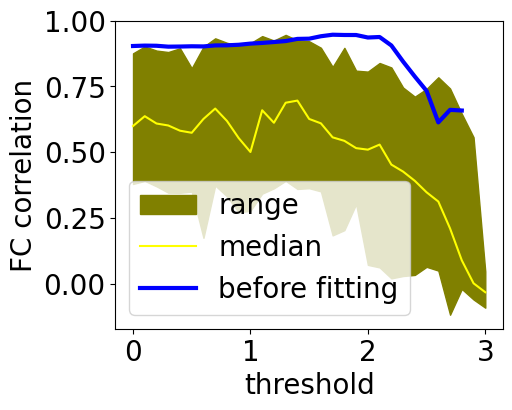

In [77]:
min_corr = torch.min(fc_corr_after_fitting, dim=0).values
median_corr = torch.median(fc_corr_after_fitting, dim=0).values
max_corr = torch.max(fc_corr_after_fitting, dim=0).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between( depytorch(threshold), depytorch(min_corr), depytorch(max_corr), color=[0.5, 0.5, 0.0], label='range' )
ax.plot( depytorch(threshold), depytorch(median_corr), color=[1.0, 1.0, 0.0], label='median' )
ax.plot( threshold_np, depytorch(best_fc_corr), color='blue', linewidth=line_width, label='before fitting' )
ax.set_xlabel('threshold')
ax.set_ylabel('FC correlation')
# ax.set_xlim([0.0, 1.5])
ax.legend()

In [18]:
fc_corr_after_temp_opt = torch.load( f=os.path.join(file_dir, 'fc_corr_group_J_inv_cov_h_0_thresh_num_31_min_0_max_3_beta_num_101_min_1e-10_max_1_updates_8_beta_length_120000_param_length_120000_param_updates_0_test_length_120000.pt'), weights_only=False )
print( fc_corr_after_temp_opt.size() )

torch.Size([101, 31])


In [18]:
fc_corr_after_temp_opt = torch.load( f=os.path.join(file_dir, 'fc_corr_group_J_inv_cov_h_0_thresh_num_31_min_0_max_3_beta_num_101_min_1e-10_max_1_updates_24_beta_length_120000_param_length_1200_param_updates_0_test_length_120000.pt'), weights_only=False )
print( fc_corr_after_temp_opt.size() )

torch.Size([101, 31])


In [19]:
print('threshold')
print( threshold.tolist() )
print('FC correlation')
print('min')
print( fc_corr_after_temp_opt.min(dim=0).values.tolist() )
print('median')
print( fc_corr_after_temp_opt.median(dim=0).values.tolist() )
print('max')
print( fc_corr_after_temp_opt.max(dim=0).values.tolist() )

threshold
[0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.9000000357627869, 1.0, 1.100000023841858, 1.2000000476837158, 1.3000000715255737, 1.399999976158142, 1.5, 1.600000023841858, 1.6999999284744263, 1.7999999523162842, 1.899999976158142, 2.0, 2.0999999046325684, 2.200000047683716, 2.299999952316284, 2.4000000953674316, 2.5, 2.5999999046325684, 2.700000047683716, 2.799999952316284, 2.9000000953674316, 3.0]
FC correlation
min
[0.9032453298568726, 0.9010182619094849, 0.9009930491447449, 0.899529218673706, 0.8997187614440918, 0.8997111916542053, 0.9011318683624268, 0.900867223739624, 0.9045178890228271, 0.9070684909820557, 0.9100511074066162, 0.9145079851150513, 0.9181650876998901, 0.9232703447341919, 0.9275112748146057, 0.9340717196464539, 0.9395280480384827, 0.9447842240333557, 0.9502743482589722, 0.9528379440307617, -0.039581432938575745, -0.0528370626270771, -0.0729691535234451

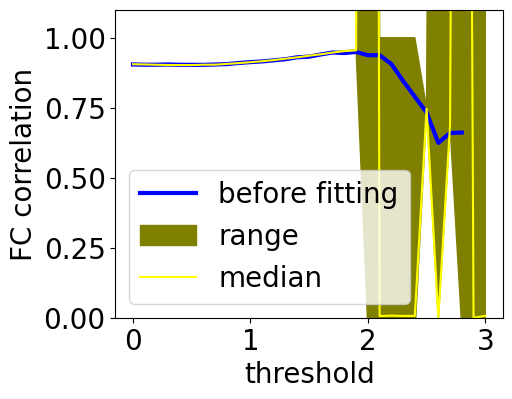

In [20]:
min_corr = torch.min(fc_corr_after_temp_opt, dim=0).values
median_corr = torch.median(fc_corr_after_temp_opt, dim=0).values
max_corr = torch.max(fc_corr_after_temp_opt, dim=0).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.plot( threshold_np, depytorch(best_fc_corr), color='blue', linewidth=line_width, label='before fitting' )
ax.fill_between( depytorch(threshold), depytorch(min_corr), depytorch(max_corr), color=[0.5, 0.5, 0.0], label='range' )
ax.plot( depytorch(threshold), depytorch(median_corr), color=[1.0, 1.0, 0.0], label='median' )
ax.set_xlabel('threshold')
ax.set_ylabel('FC correlation')
ax.set_ylim([0.0, 1.1])
ax.legend()

In [22]:
fc_corr_after_fitting = torch.load( f=os.path.join(file_dir, 'fc_corr_group_J_inv_cov_h_0_thresh_num_31_min_0_max_3_beta_num_101_min_1e-10_max_1_updates_24_beta_length_120000_param_length_1200_param_updates_6000_test_length_120000.pt'), weights_only=False )
print( fc_corr_after_fitting.size() )

torch.Size([101, 31])


In [23]:
print('threshold')
print( threshold.tolist() )
print('FC correlation')
print('min')
print( fc_corr_after_fitting.min(dim=0).values.tolist() )
print('median')
print( fc_corr_after_fitting.median(dim=0).values.tolist() )
print('max')
print( fc_corr_after_fitting.max(dim=0).values.tolist() )

threshold
[0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.9000000357627869, 1.0, 1.100000023841858, 1.2000000476837158, 1.3000000715255737, 1.399999976158142, 1.5, 1.600000023841858, 1.6999999284744263, 1.7999999523162842, 1.899999976158142, 2.0, 2.0999999046325684, 2.200000047683716, 2.299999952316284, 2.4000000953674316, 2.5, 2.5999999046325684, 2.700000047683716, 2.799999952316284, 2.9000000953674316, 3.0]
FC correlation
min
[0.40777742862701416, 0.24630855023860931, 0.3440976142883301, 0.36770617961883545, 0.38309144973754883, 0.39653635025024414, 0.39466238021850586, 0.28984740376472473, 0.3448127210140228, 0.32037457823753357, 0.34186288714408875, 0.3284287452697754, 0.33853214979171753, 0.38126376271247864, 0.39541152119636536, 0.37771257758140564, 0.4165445864200592, 0.4038584530353546, 0.3809700906276703, 0.1797613799571991, 0.09220369905233383, 0.1322139948606491, 0.09291

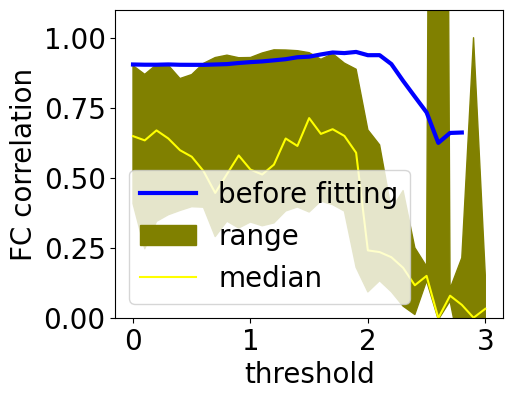

In [24]:
min_corr = torch.min(fc_corr_after_fitting, dim=0).values
median_corr = torch.median(fc_corr_after_fitting, dim=0).values
max_corr = torch.max(fc_corr_after_fitting, dim=0).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.plot( threshold_np, depytorch(best_fc_corr), color='blue', linewidth=line_width, label='before fitting' )
ax.fill_between( depytorch(threshold), depytorch(min_corr), depytorch(max_corr), color=[0.5, 0.5, 0.0], label='range' )
ax.plot( depytorch(threshold), depytorch(median_corr), color=[1.0, 1.0, 0.0], label='median' )
ax.set_xlabel('threshold')
ax.set_ylabel('FC correlation')
ax.set_ylim([0.0, 1.1])
ax.legend()

In [20]:
h_inv_cov_diag_corr = torch.load( os.path.join(file_dir, 'corr_h_inv_cov_thresh_num_31_min_0_max_3_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False )
print( h_inv_cov_diag_corr.size() )

torch.Size([101, 31])


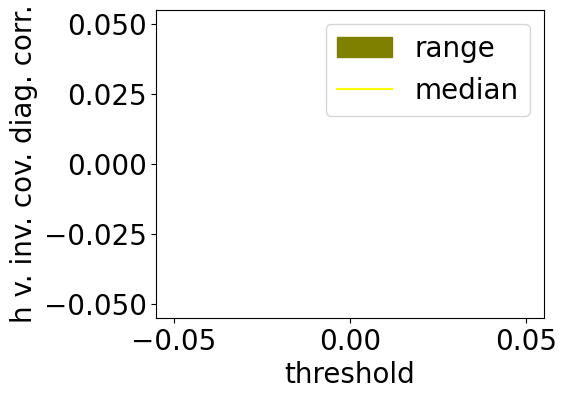

In [22]:
min_corr = torch.min(h_inv_cov_diag_corr, dim=0).values
median_corr = torch.median(h_inv_cov_diag_corr, dim=0).values
max_corr = torch.max(h_inv_cov_diag_corr, dim=0).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between( depytorch(threshold), depytorch(min_corr), depytorch(max_corr), color=[0.5, 0.5, 0.0], label='range' )
ax.plot( depytorch(threshold), depytorch(median_corr), color=[1.0, 1.0, 0.0], label='median' )
ax.set_xlabel('threshold')
ax.set_ylabel('h v. inv. cov. diag. corr.')
# ax.set_xlim([0.0, 1.5])
ax.legend()

In [23]:
print(  torch.count_nonzero( torch.isnan(h_inv_cov_diag_corr) )  )

tensor(3131, device='cuda:0')


In [12]:
inv_cov = torch.load( os.path.join(file_dir, 'inv_cov_J_inv_cov_thresh_num_31_min_0_max_3.pt'), weights_only=False )
print( inv_cov.size() )

torch.Size([31, 360, 360])


In [13]:
inv_cov_diag = torch.diagonal( inv_cov, dim1=-2, dim2=-1 )
print(  inv_cov_diag.size(), torch.count_nonzero( torch.isnan(inv_cov_diag) )  )

torch.Size([31, 360]) tensor(0, device='cuda:0')


In [14]:
model = torch.load( os.path.join(file_dir, 'ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False )
print( model.h.size() )

torch.Size([101, 31, 360])


h at threshold 0.5=2.75inv. cov. diag. at threshold 0.5+-7.8, R^2=0.216, corr.=0.464


(2.754528045654297, -7.8035383224487305)

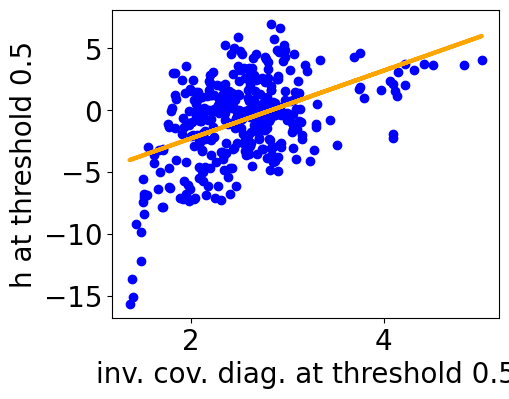

In [23]:
threshold_index = 5
selected_threshold = threshold[threshold_index]
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=inv_cov_diag[threshold_index,:], param=model.h[0,threshold_index,:], feature_name=f'inv. cov. diag. at threshold {selected_threshold:.3g}', param_name=f'h at threshold {selected_threshold:.3g}' )

h at threshold 0.5=9.48sqrt(inv. cov. diag.) at threshold 0.5+-15.8, R^2=0.239, corr.=0.488


(9.48179817199707, -15.82619571685791)

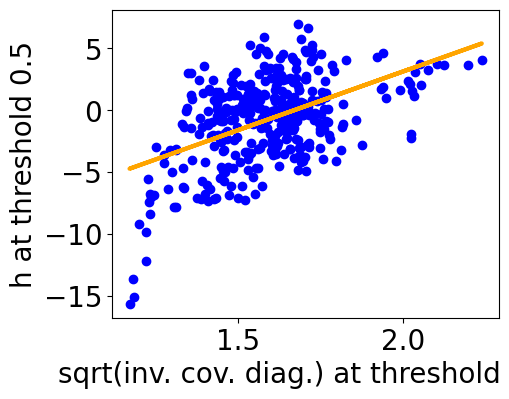

In [24]:
threshold_index = 5
selected_threshold = threshold[threshold_index]
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=inv_cov_diag[threshold_index,:].sqrt(), param=model.h[0,threshold_index,:], feature_name=f'sqrt(inv. cov. diag.) at threshold {selected_threshold:.3g}', param_name=f'h at threshold {selected_threshold:.3g}' )

h at threshold 1=10.7log. inv. cov. diag. at threshold 1+-16, R^2=0.332, corr.=0.575


(10.710334777832031, -15.974413871765137)

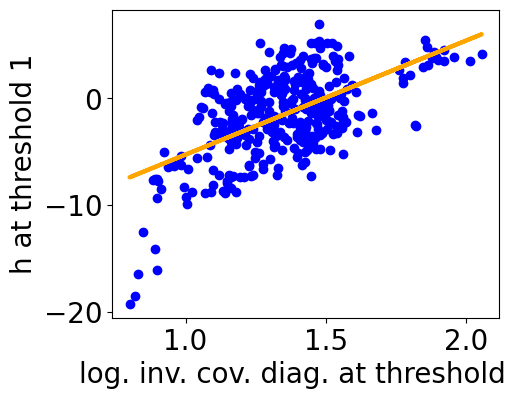

In [25]:
threshold_index = 10
selected_threshold = threshold[threshold_index]
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=inv_cov_diag[threshold_index,:].log(), param=model.h[0,threshold_index,:], feature_name=f'log. inv. cov. diag. at threshold {selected_threshold:.3g}', param_name=f'h at threshold {selected_threshold:.3g}' )

h at threshold 1=-43.11/(inv. cov. diag.) at threshold 1+9.91, R^2=0.372, corr.=-0.608


(-43.071224212646484, 9.905147552490234)

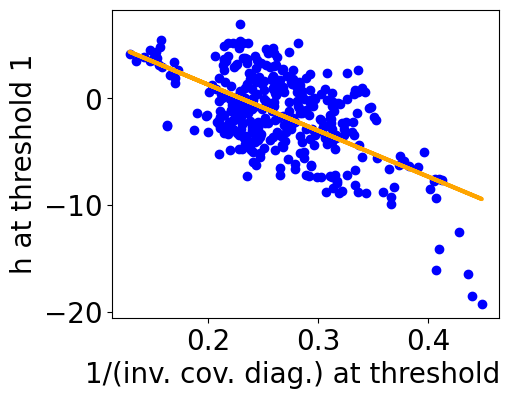

In [45]:
threshold_index = 10
selected_threshold = threshold[threshold_index]
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=1.0/inv_cov_diag[threshold_index,:], param=model.h[0,threshold_index,:], feature_name=f'1/(inv. cov. diag.) at threshold {selected_threshold:.3g}', param_name=f'h at threshold {selected_threshold:.3g}' )

In [28]:
mean_state = torch.load( os.path.join(file_dir, 'mean_state_thresholds_31_min_0_max_3.pt'), weights_only=False )
print( mean_state.size() )

torch.Size([31, 360])


mean state at threshold 3=-2.69e-05inv. cov. diag. at threshold 3+-0.991, R^2=0.643, corr.=-0.799


(-2.6850855647353455e-05, -0.9910810589790344)

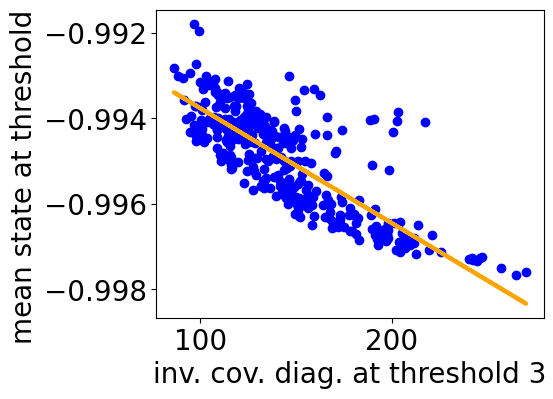

In [33]:
threshold_index = 30
selected_threshold = threshold[threshold_index]
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=inv_cov_diag[threshold_index,:], param=mean_state[threshold_index,:], feature_name=f'inv. cov. diag. at threshold {selected_threshold:.3g}', param_name=f'mean state at threshold {selected_threshold:.3g}' )

h at threshold 3=116mean state at threshold 3+114, R^2=0.808, corr.=0.896


(115.55109405517578, 114.17842864990234)

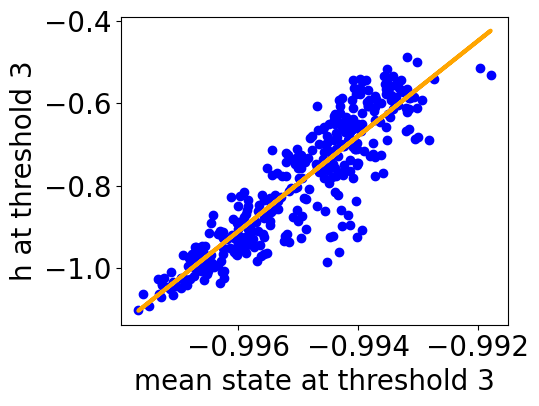

In [38]:
threshold_index = 30
selected_threshold = threshold[threshold_index]
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=mean_state[threshold_index,:], param=model.h[0,threshold_index,:], feature_name=f'mean state at threshold {selected_threshold:.3g}', param_name=f'h at threshold {selected_threshold:.3g}' )

In [46]:
mean_h = model.h.mean(dim=0)

h at threshold 3=-0.00269inv. cov. diag. at threshold 3+-16.1, R^2=0.352, corr.=-0.592


(-0.0026936742942780256, -16.14862632751465)

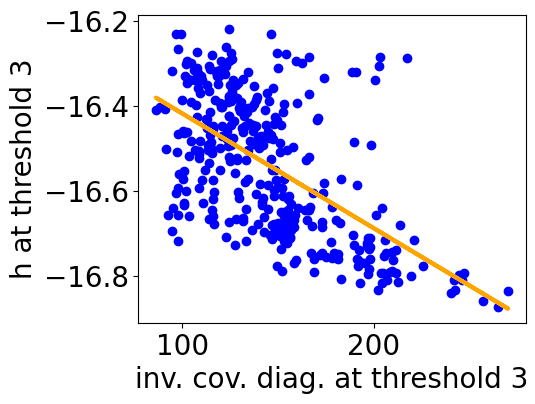

In [51]:
threshold_index = 30
selected_threshold = threshold[threshold_index]
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=inv_cov_diag[threshold_index,:], param=mean_h[threshold_index,:], feature_name=f'inv. cov. diag. at threshold {selected_threshold:.3g}', param_name=f'h at threshold {selected_threshold:.3g}' )